In [1]:
import json
import re
import sys
from pathlib import Path
from iohblade.loggers import ExperimentLogger
from llamea.ast_features import extract_ast_features
from iohblade.loggers import ExperimentLogger
from iohblade.plots import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


In [2]:
logger = ExperimentLogger('/home/neocortex/repos/BLADE/results/MABBOB_guided', True)
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines')
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines2')
log_data = logger.get_data()
log_data.head()

,method_name,problem_name,llm_name,method,problem,llm,solution,log_dir,seed
0,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '1075fb19-2d1a-4413-9005-a84684f12f29',...",run-ES-MA_BBOB-2,2
1,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '97b09f41-16dd-4b97-b046-9dcd1f56a34c',...",run-ES-MA_BBOB-1,1
2,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '008715f8-d903-40a3-b331-ffbbeff335d1',...",run-ES-MA_BBOB-5,5
3,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '2a2b9226-c20f-44ac-95be-b81a5536bba3',...",run-ES-MA_BBOB-3,3
4,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '79bbe510-8d01-4e86-bb38-258c33bcbd1d',...",run-ES-MA_BBOB-4,4


In [3]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['ES (gemini)', 'ES-guided (gemini)', 'ES-guided', 'ES', 'LHNS:vns', 'MCTS_AHD']
['MA_BBOB']


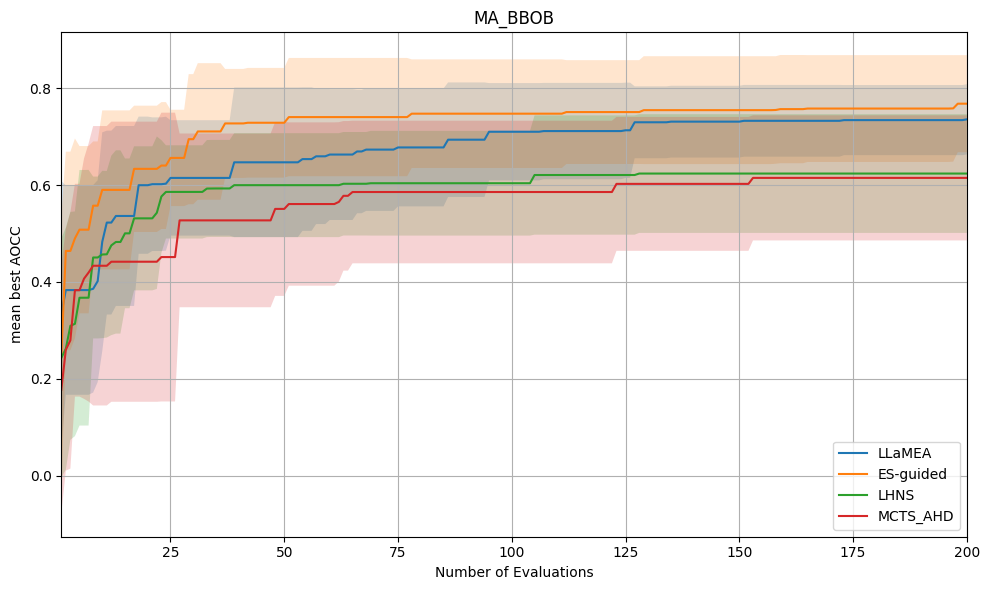

In [4]:
fig = plot_convergence(logger, metric="AOCC", methods=["ES", "ES-guided", "LHNS:vns","MCTS_AHD"], save=False, return_fig=True, budget=200, separate_lines=False)
ax = fig.axes[0]   # or however you're getting your axis

handles, previous_labels = ax.get_legend_handles_labels()
new_labels = []
for label in previous_labels:
    if label == "ES":
        new_labels.append("LLaMEA")
    elif label == "LHNS:vns":
        new_labels.append("LHNS")
    else:
        new_labels.append(label)
ax.legend(handles=handles, labels=new_labels)
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
plt.savefig("MABBOB-aocc.png")
plt.show()

In [5]:
data = logger.get_problem_data("MA_BBOB")

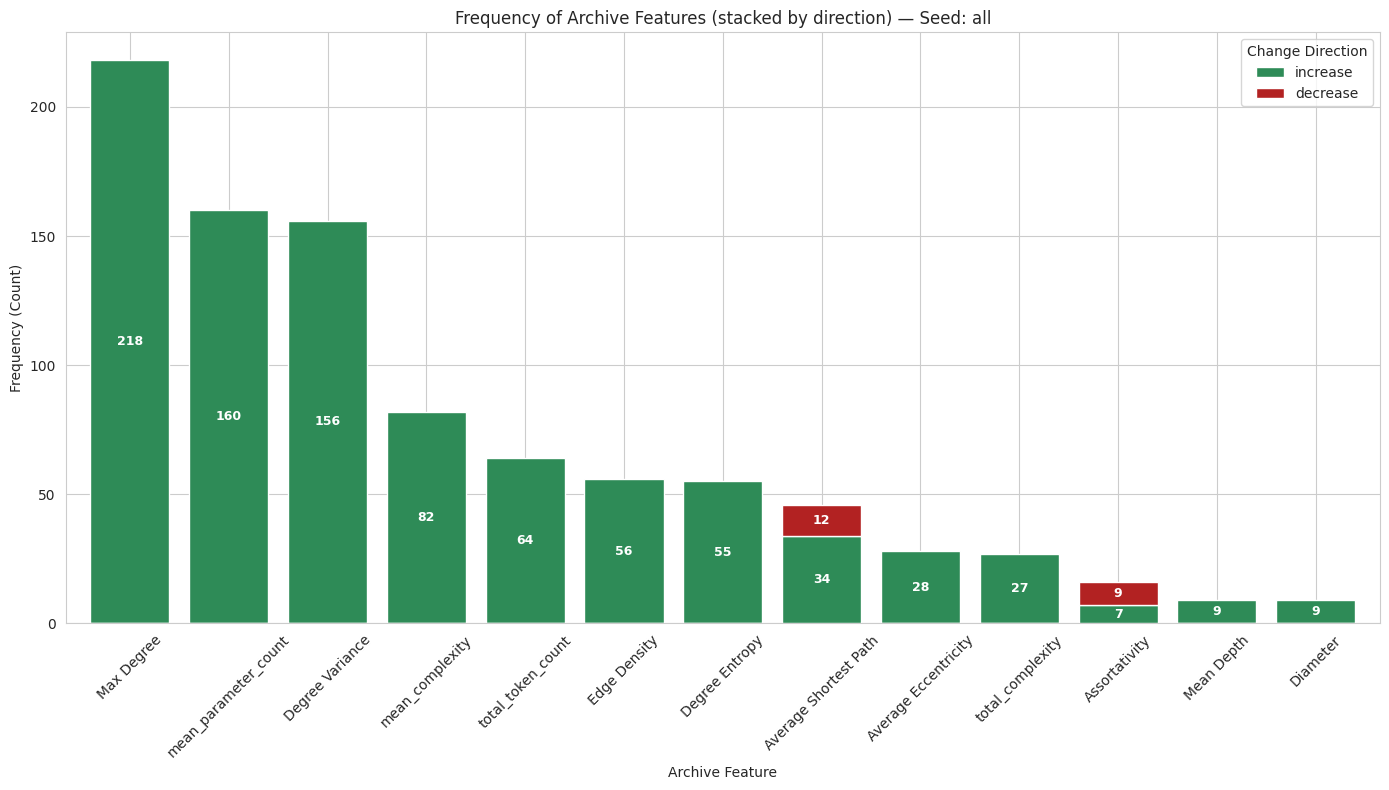

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_archive_feature_stacked_histograms_pandas(
    df: pd.DataFrame,
    name: str = "guided",
    outdir: str | None = None,
    feature_col: str = "archive_feature",
    direction_col: str = "archive_direction",
    seed_col: str = "seed",
    directions_order: tuple[str, ...] = ("increase", "decrease"),
    direction_colors: dict[str, str] | None = None,
    min_count_to_label: int = 1,
):
    """
    Proper stacked bar charts via pandas pivot + stacked bar plotting.

    Creates one plot per seed, plus one combined plot for all seeds.
    """

    if direction_colors is None:
        direction_colors = {"increase": "seagreen", "decrease": "firebrick"}

    required = {seed_col, feature_col, direction_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # basic cleanup
    df = df.copy()
    df[feature_col] = df[feature_col].fillna("").astype(str)
    df[direction_col] = df[direction_col].fillna("").astype(str)
    df = df[df[feature_col].str.strip() != ""]

    if df.empty:
        print("No data after filtering empty archive_feature.")
        return

    def _savepath(fname: str) -> str:
        return fname if outdir is None else str(pd.Path(outdir) / fname)  # type: ignore

    def _make_stacked(seed_label, df_sub):
        # counts -> wide table (features x directions)
        counts = (
            df_sub.groupby([feature_col, direction_col])
                  .size()
                  .unstack(fill_value=0)
        )

        # ensure desired direction columns exist + order them
        for d in directions_order:
            if d not in counts.columns:
                counts[d] = 0
        counts = counts.loc[:, list(directions_order)]

        # order features by total height
        feature_order = counts.sum(axis=1).sort_values(ascending=False).index
        counts = counts.loc[feature_order]

        # plot
        fig, ax = plt.subplots(figsize=(14, 8))
        colors = [direction_colors.get(d, None) for d in counts.columns]
        counts.plot(kind="bar", stacked=True, ax=ax, color=colors, width=0.8)

        ax.set_title(f"Frequency of Archive Features (stacked by direction) — Seed: {seed_label}")
        ax.set_xlabel("Archive Feature")
        ax.set_ylabel("Frequency (Count)")
        ax.tick_params(axis="x", rotation=45)
        ax.legend(title="Change Direction")

        # annotate each stacked segment
        # iterate bars per direction (container order matches columns)
        for container in ax.containers:
            for patch in container.patches:
                height = patch.get_height()
                if height >= min_count_to_label:
                    x = patch.get_x() + patch.get_width() / 2
                    y = patch.get_y() + height / 2
                    ax.text(x, y, f"{int(height)}", ha="center", va="center",
                            fontsize=9, fontweight="bold", color="white")

        fig.tight_layout()

        file_name = f"archive_feature_stacked_histogram_{name}_{seed_label}.png"
        plt.savefig(_savepath(file_name), dpi=200)
        plt.show()
        plt.close(fig)

    # per-seed
    #for seed_val, df_seed in df.groupby(seed_col, sort=False):
    #    _make_stacked(seed_val, df_seed)

    # all together
    _make_stacked("all", df)


# Example usage (same as yours)
plot_archive_feature_stacked_histograms_pandas(
    data[data["method_name"] == "ES-guided"],
    name="ES-guided"
)


/tmp/ipykernel_2341298/3340924519.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consistency'] = df.apply(check_direction_consistency, axis=1)


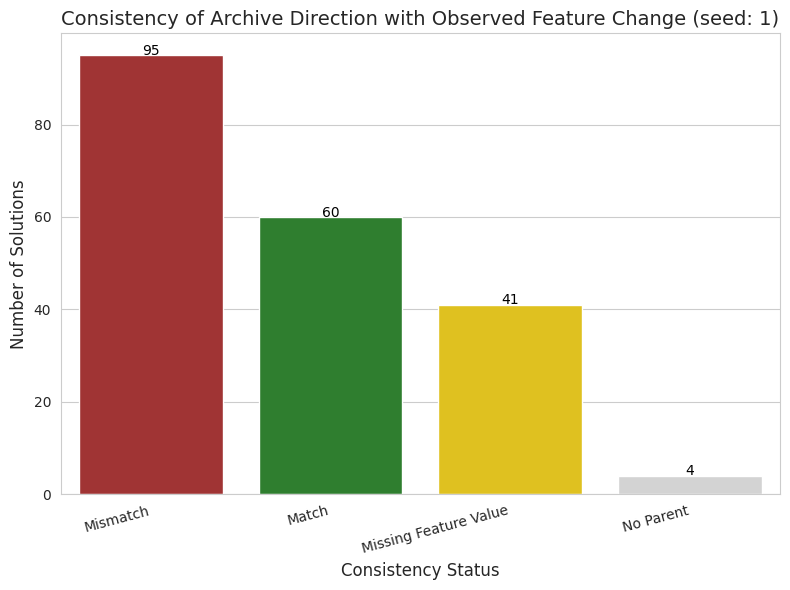

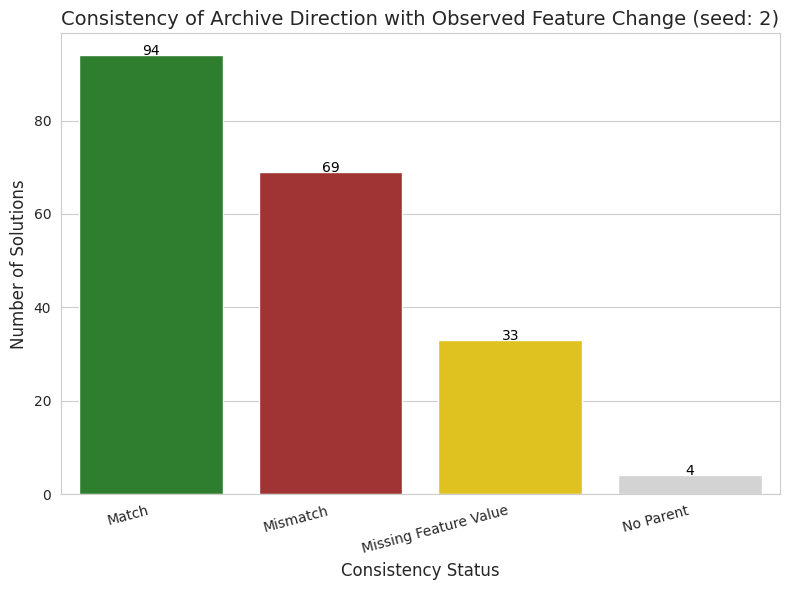

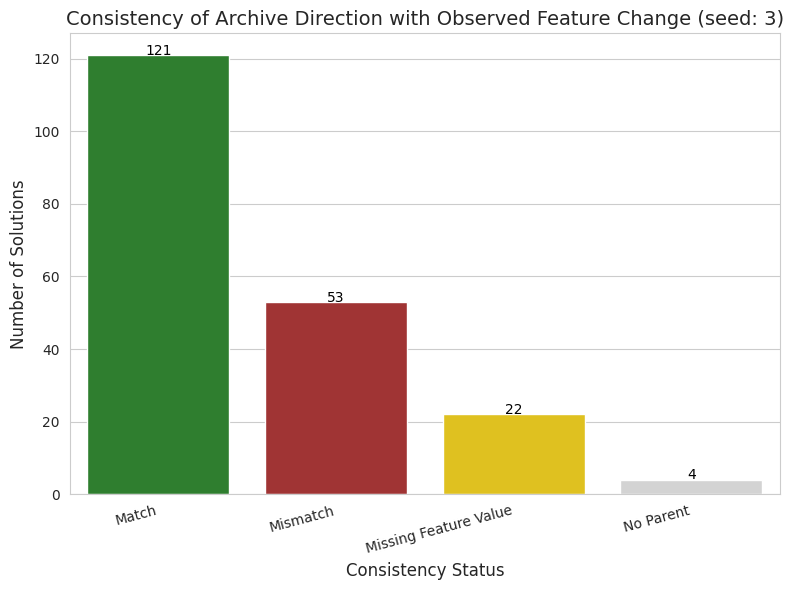

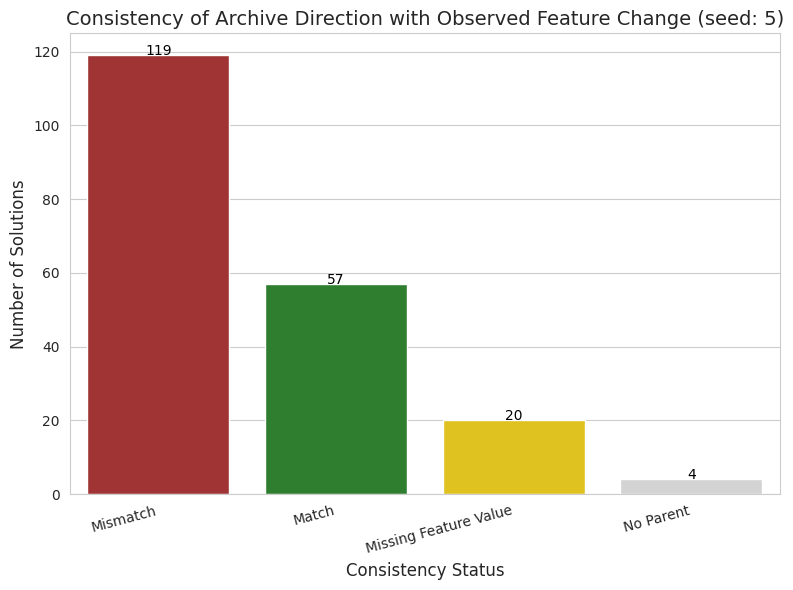

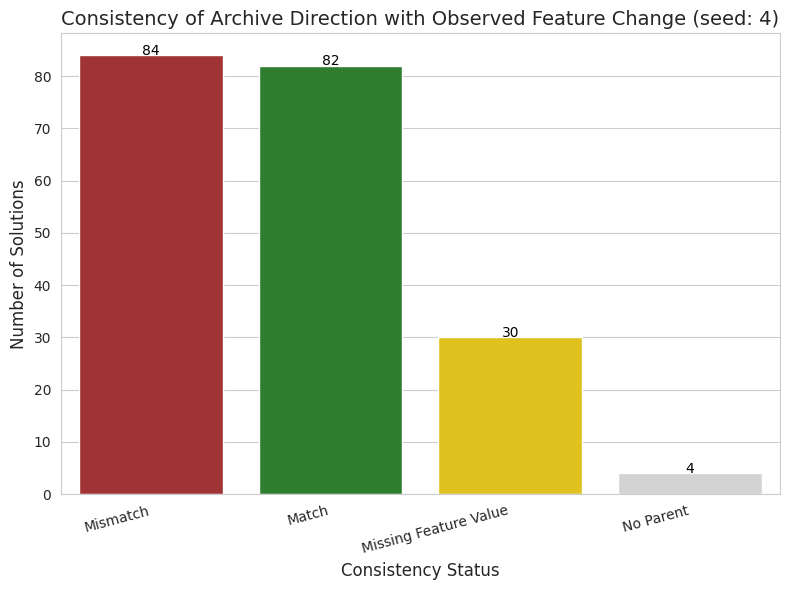

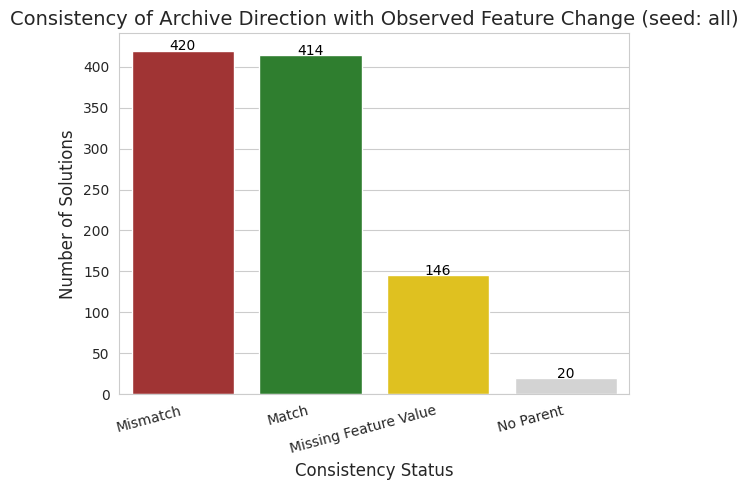

,Consistency Status,Count
0,Mismatch,95
1,Match,60
2,Missing Feature Value,41
3,No Parent,4
4,Match,94
5,Mismatch,69
6,Missing Feature Value,33
7,No Parent,4
8,Match,121
9,Mismatch,53


In [7]:
# The next thing is that I want to see how often the "archive_feature" given the "archive_direction" changed from parent to child solution. 

def analyze_archive_direction_consistency(df, name="ES-guided"):
    """
    Analyzes the consistency between the observed feature value change 
    (parent to child) and the recorded 'archive_direction', and visualizes it.

    Args:
        df (pd.DataFrame): DataFrame with 'id', 'parent_ids', 'ast_features',
        'archive_feature', and 'archive_direction'.

    Returns:
        pd.DataFrame: DataFrame containing the Match/Mismatch counts.
    """
    # 1. Index the DataFrame by 'id' for fast lookups
    df_indexed = df.set_index('id')

    def normalize_key(key):
        """
        Converts any feature key (e.g., 'Mean_Complexity', 'Max Degree') 
        to a standardized format (e.g., 'mean complexity') for robust lookup.
        """
        key = str(key).lower()
        # Replace underscores with spaces (handles snake_case keys like mean_complexity)
        key = key.replace('_', ' ')
        # Collapse multiple spaces and strip leading/trailing spaces
        return ' '.join(key.split()).strip()
    

    def get_feature_value(ast_features_dict, target_feature):
        """Looks up the value in the AST features using the normalized key."""
        # Normalize the target feature name (from archive_feature column)
        normalized_target = normalize_key(target_feature)
        
        # Create a new dictionary with ALL keys normalized for efficient lookup
        normalized_dict = {normalize_key(k): v for k, v in ast_features_dict.items()}
        
        # Look up the value
        return normalized_dict.get(normalized_target)

    def check_direction_consistency(row):
        """
        Compares the observed change in feature value (parent -> child) 
        with the recorded 'archive_direction'.
        """
        parent_ids = row['parent_ids']
        archive_feature = row['archive_feature']
        archive_direction = row['archive_direction']

        # Skip rows without a parent
        if not parent_ids:
            return 'No Parent'

        # Assume only one parent ID in the list
        parent_id = parent_ids[0]

        try:
            # 2. Lookup Parent Row and Feature Value
            parent_row = df_indexed.loc[parent_id]
            
            # Get feature values using the robust lookup function
            v_parent = get_feature_value(parent_row['ast_features'], archive_feature)
            v_child = get_feature_value(row['ast_features'], archive_feature)

            # Handle cases where feature values are missing
            if v_parent is None or v_child is None:
                return 'Missing Feature Value'

            # 3. Determine Observed Direction
            if v_child > v_parent:
                observed_direction = 'increase'
            elif v_child < v_parent:
                observed_direction = 'decrease'
            else:
                observed_direction = 'no change'

            # 4. Check for Match
            # 'no change' is considered a mismatch for 'increase'/'decrease' targets
            if observed_direction == archive_direction:
                return 'Match'
            else:
                # If 'no change' occurred, we classify it as Mismatch against the target direction
                return 'Mismatch'

        except KeyError:
            # Handle case where parent ID is not found in the DataFrame
            return 'Parent Not Found'
        except Exception:
            # Catch other potential errors
            return 'Error in Calculation'

    # Apply the check to every row
    df['consistency'] = df.apply(check_direction_consistency, axis=1)

    # Get all unique seeds
    unique_seeds = df['seed'].unique()

    # Set up plotting style
    sns.set_style("whitegrid")

    all_consistency_counts = pd.DataFrame()

    for seed in unique_seeds:
        # Filter data for the current seed
        df_seed = df[df['seed'] == seed]

        # 5. Count the matches, mismatches, and other categories
        consistency_counts = df_seed['consistency'].value_counts().reset_index()
        consistency_counts.columns = ['Consistency Status', 'Count']
        
        # 6. Visualization (Bar Chart)
        plt.figure(figsize=(8, 6))
        
        # Define a clear color palette
        color_map = {'Match': 'forestgreen', 'Mismatch': 'firebrick', 'No Parent': 'lightgray', 
                    'Parent Not Found': 'orange', 'Missing Feature Value': 'gold', 'Error in Calculation': 'black'}
        
        # Ensure the colors are only applied to the statuses that are present in the counts
        plot_colors = [color_map.get(status, 'gray') for status in consistency_counts['Consistency Status']]
        
        sns.barplot(
            data=consistency_counts,
            x='Consistency Status',
            y='Count',
            hue='Consistency Status',
            legend=False,
            palette=plot_colors,
            order=consistency_counts['Consistency Status']
        )
        
        plt.title(f'Consistency of Archive Direction with Observed Feature Change (seed: {seed})', fontsize=14)
        plt.xlabel('Consistency Status', fontsize=12)
        plt.ylabel('Number of Solutions', fontsize=12)
        plt.xticks(rotation=15, ha='right')
        
        # Add counts on top of bars
        for index, row in consistency_counts.iterrows():
            plt.text(index, row['Count'] + 0.05, str(row['Count']), color='black', ha="center")

        plt.tight_layout()
        file_name = f'archive_direction_consistency_histogram_{name}_{seed}.png'
        plt.savefig(file_name)
        plt.show()
        plt.close()

        all_consistency_counts = pd.concat([all_consistency_counts, consistency_counts], ignore_index=True)

    df_seed = df.copy()
    seed = "all"

    # 5. Count the matches, mismatches, and other categories
    consistency_counts = df_seed['consistency'].value_counts().reset_index()
    consistency_counts.columns = ['Consistency Status', 'Count']
    
    # 6. Visualization (Bar Chart)
    plt.figure(figsize=(6, 5))
    
    # Define a clear color palette
    color_map = {'Match': 'forestgreen', 'Mismatch': 'firebrick', 'No Parent': 'lightgray', 
                'Parent Not Found': 'orange', 'Missing Feature Value': 'gold', 'Error in Calculation': 'black'}
    
    # Ensure the colors are only applied to the statuses that are present in the counts
    plot_colors = [color_map.get(status, 'gray') for status in consistency_counts['Consistency Status']]
    
    sns.barplot(
        data=consistency_counts,
        x='Consistency Status',
        y='Count',
        hue='Consistency Status',
        legend=False,
        palette=plot_colors,
        order=consistency_counts['Consistency Status']
    )
    
    plt.title(f'Consistency of Archive Direction with Observed Feature Change (seed: {seed})', fontsize=14)
    plt.xlabel('Consistency Status', fontsize=12)
    plt.ylabel('Number of Solutions', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    
    # Add counts on top of bars
    for index, row in consistency_counts.iterrows():
        plt.text(index, row['Count'] + 0.05, str(row['Count']), color='black', ha="center")

    plt.tight_layout()
    file_name = f'archive_direction_consistency_histogram_{name}_{seed}.png'
    plt.savefig(file_name)
    plt.show()
    plt.close()

    all_consistency_counts = pd.concat([all_consistency_counts, consistency_counts], ignore_index=True)
    return all_consistency_counts

all_consistency_counts = analyze_archive_direction_consistency(data[data['method_name'] == "ES-guided"], "ES-guided-global")
#all_consistency_counts = analyze_archive_direction_consistency(data[data['method_name'] == "ES-guided-new"], "ES-guided-local")
all_consistency_counts

/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`.

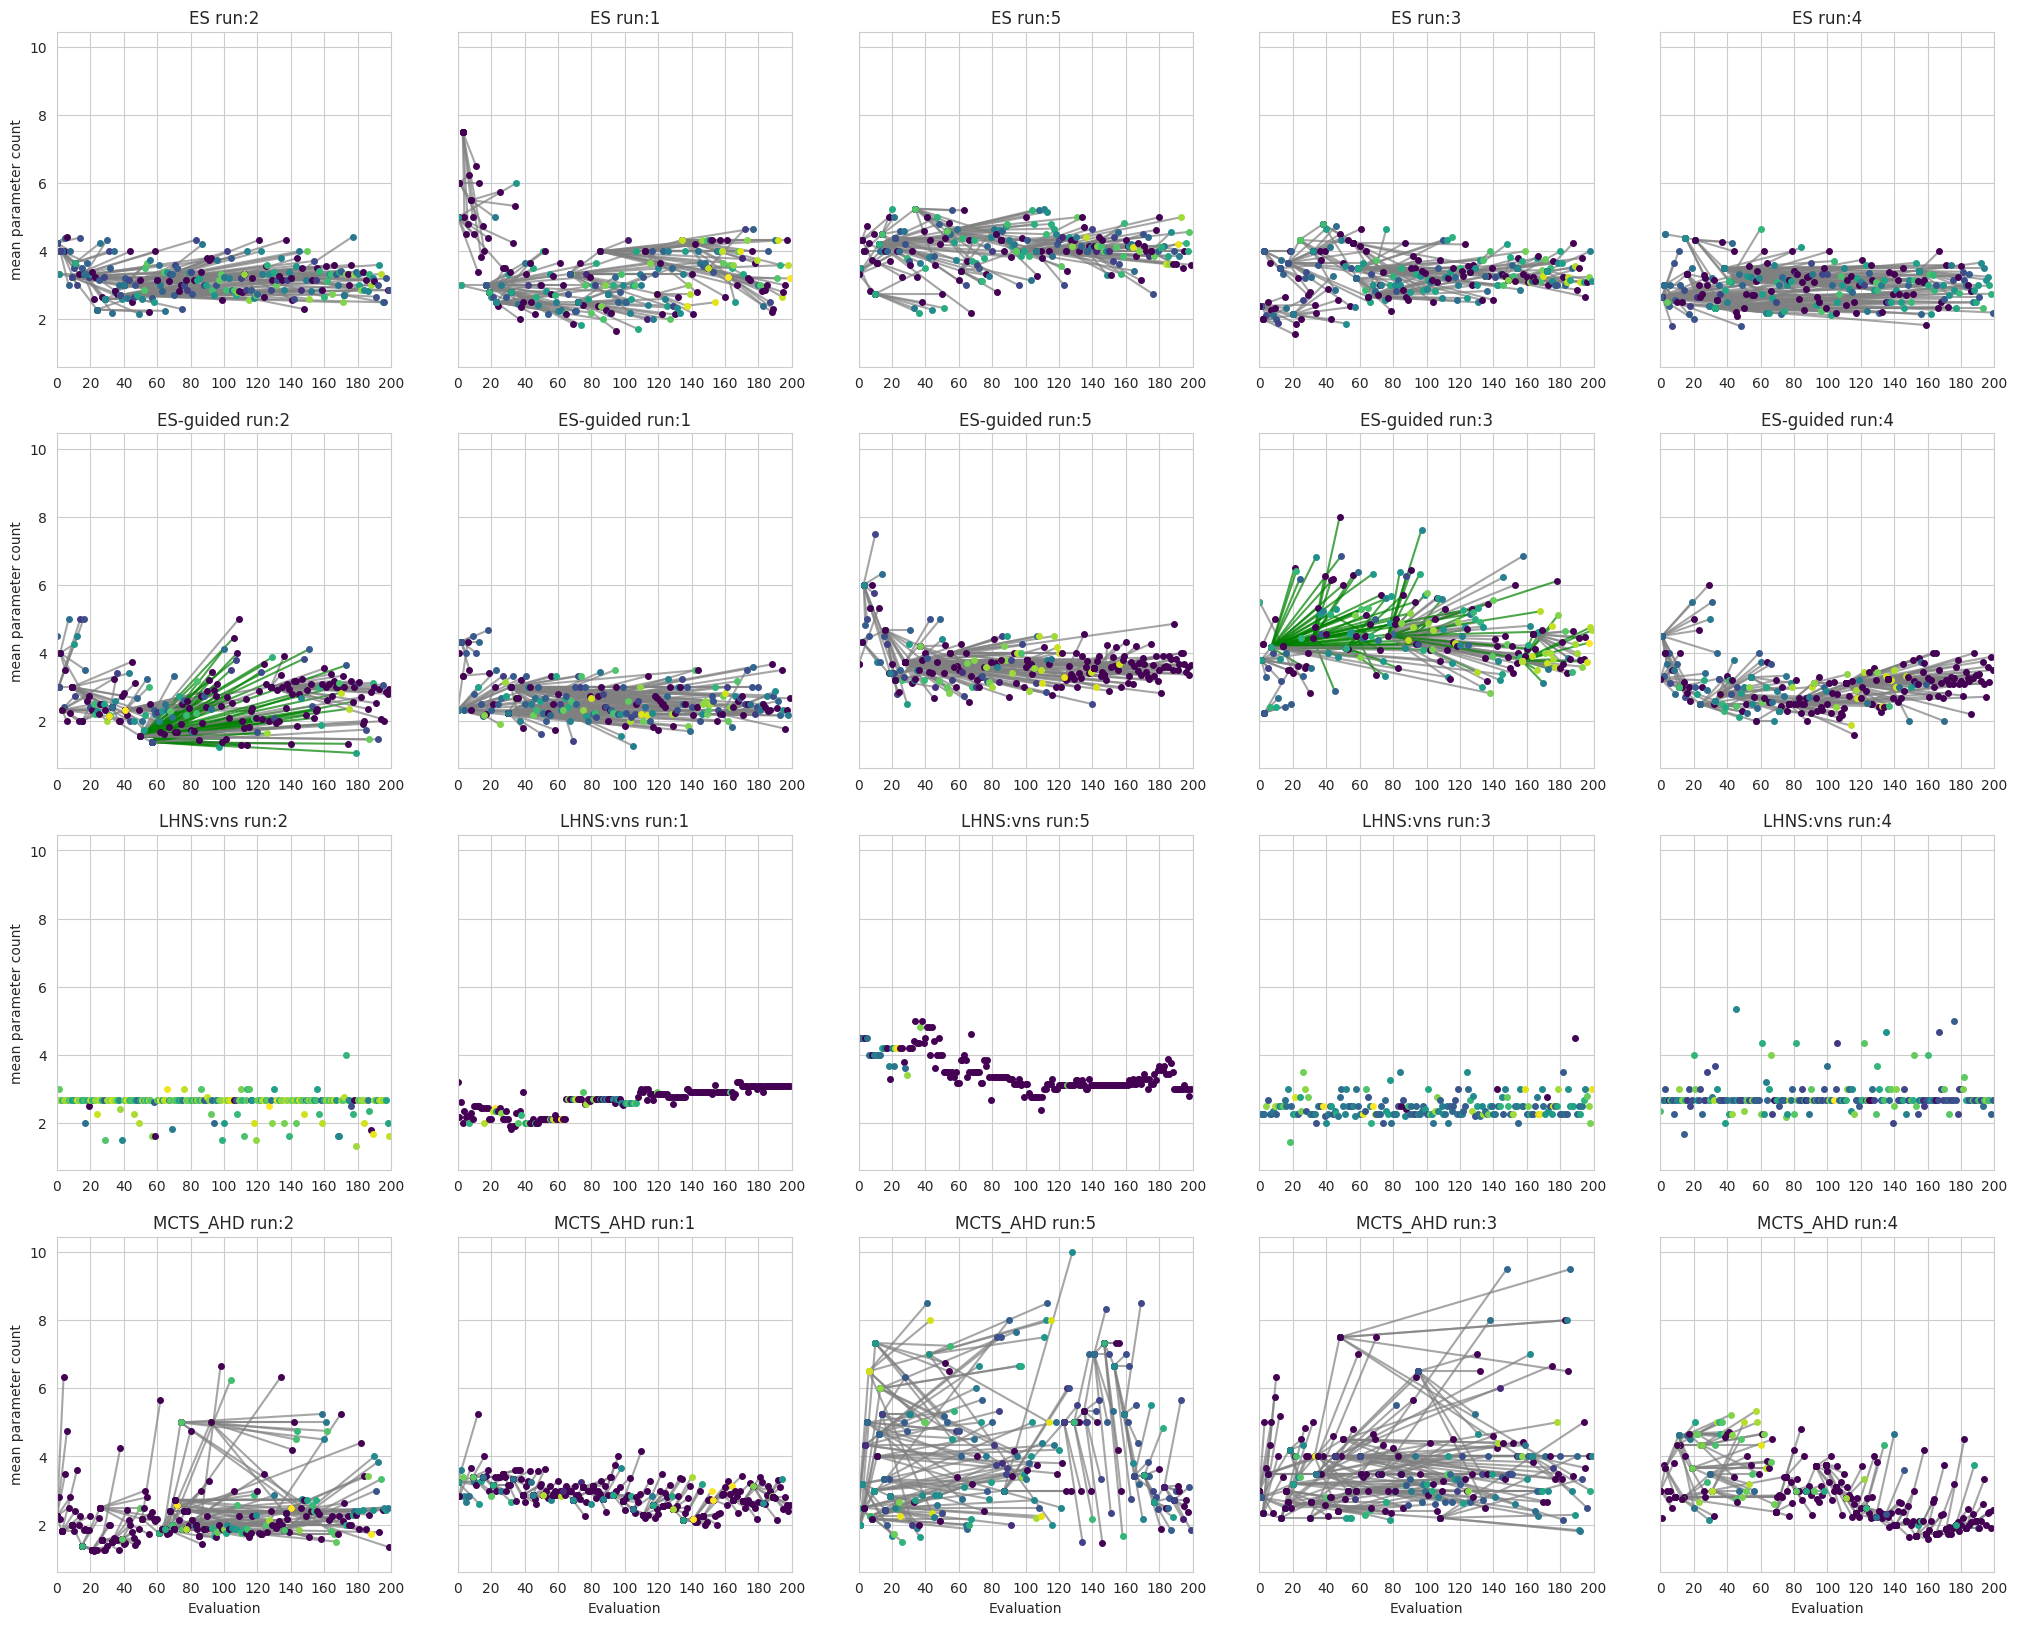

/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/neocortex/repos/BLADE/iohblade/plots.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`.

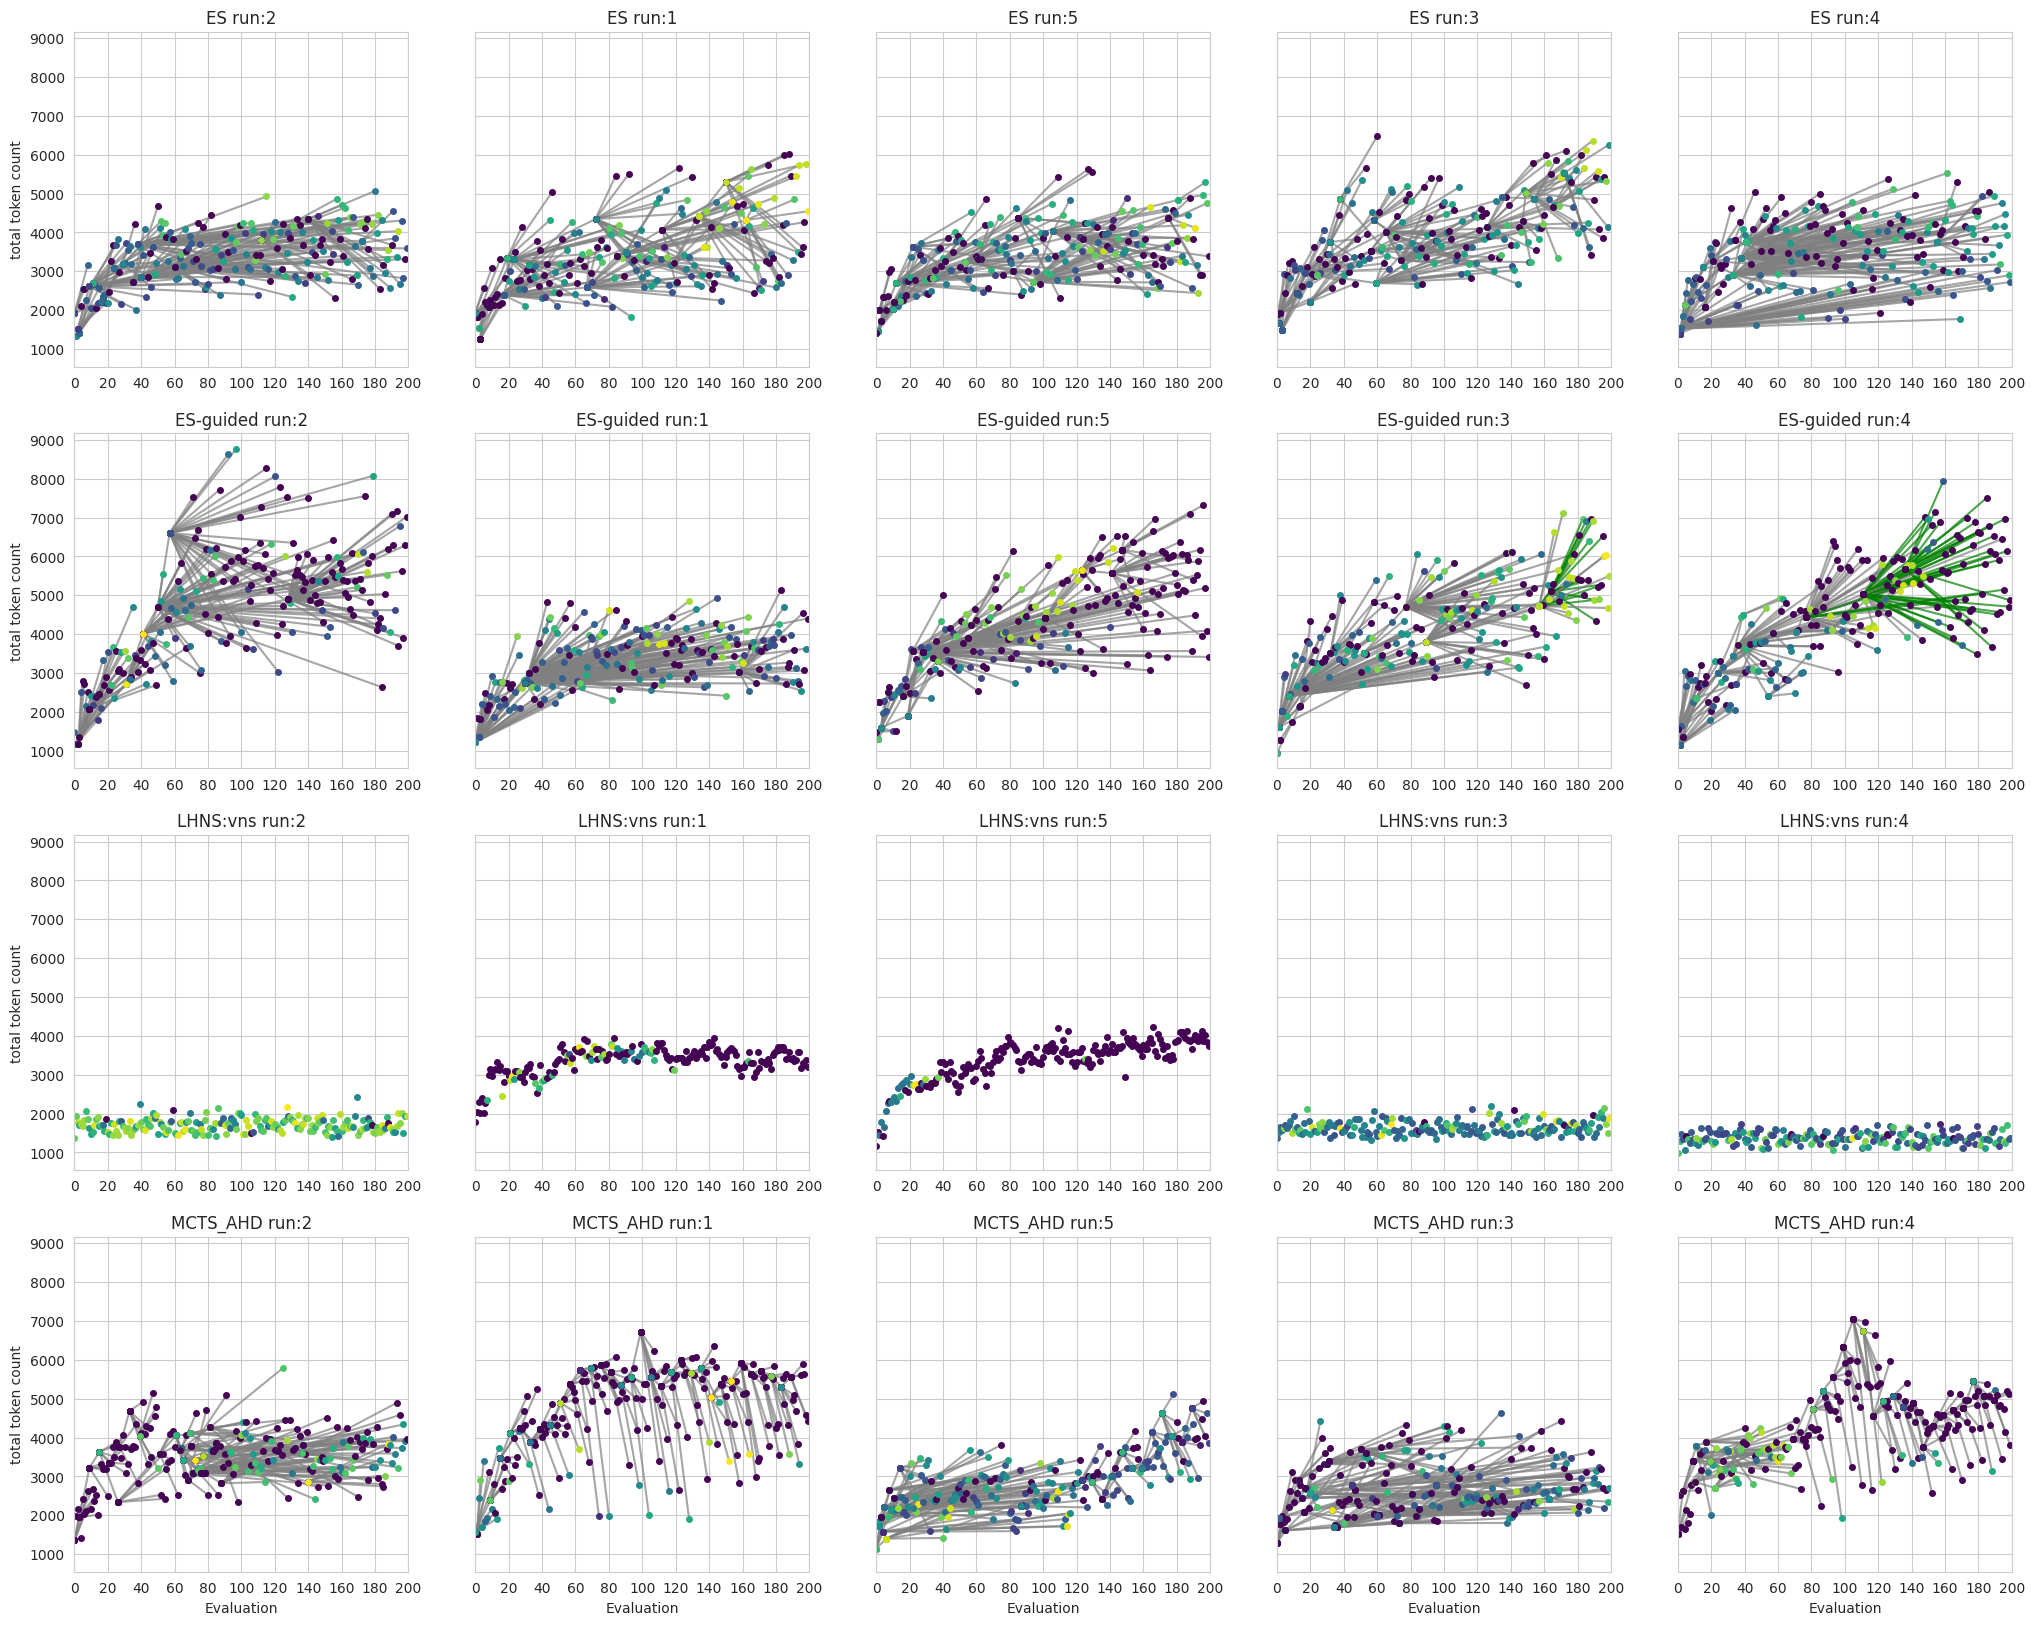

In [8]:
plot_experiment_CEG(logger, methods=["ES", "ES-guided", "LHNS:vns","MCTS_AHD"], markersize=4, save=False, budget=200, max_seeds=5, metric="mean_parameter_count") 

plot_experiment_CEG(logger, methods=["ES", "ES-guided", "LHNS:vns","MCTS_AHD"], markersize=4, save=False, budget=200, max_seeds=5, metric="total_token_count") 